In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import glob
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
import findspark
from pyspark.sql.functions import when

In [2]:
findspark.init()
findspark.find()

'C:\\Spark\\spark-3.0.3-bin-hadoop2.7'

In [3]:
spark = SparkSession \
.builder \
.appName("Phân tích điểm thi đai học") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()


# Import all file csv from data folder

In [4]:
path = "./data"
AllCSV = [i for i in glob.glob(path+ "/*.csv")]
AllCSV

['./data\\Diemthi2019.csv',
 './data\\Diemthi2020.csv',
 './data\\Diemthi2021.csv']

# Read csv

In [5]:
all_dataframes = [] # list to store each data frame separately
for csv in AllCSV:
    df = spark.read.csv(csv, header = True)
    all_dataframes.append(df)

In [6]:
df_2019 = all_dataframes[0]
df_2019.show(5)

+---+----+----+----+----+----------------+---------+----+----+----+----+--------+
|_c0| Dia|GDCD| Hoa|  Li|Ma_mon_ngoai_ngu|Ngoai_ngu|Sinh|  Su|Toan| Van|     sbd|
+---+----+----+----+----+----------------+---------+----+----+----+----+--------+
|  0|7.75|8.75|null|null|              N1|      7.6|null|8.25| 8.2| 8.0|24008611|
|  1|null|null| 4.5|8.25|              N1|      8.0| 6.0|null| 8.6|6.17|51000032|
|  2|4.25|5.75|null|null|            null|     null|null| 4.0| 5.2|4.75|51000005|
|  3|4.75| 5.0|null|null|            null|     null|null|2.25| 4.4| 4.5|51000021|
|  4|8.25| 7.5|null|null|              N1|      4.4|null|7.75| 5.8| 6.0|51000013|
+---+----+----+----+----+----------------+---------+----+----+----+----+--------+
only showing top 5 rows



In [7]:
df_2020 = all_dataframes[1]
df_2020.show(5)

+--------+----+-------+---------+------+-------+--------+-------+------+----+------+
|     SBD|Toan|Ngu_van|Ngoai_ngu|Vat_ly|Hoa_hoc|Sinh_hoc|Lich_su|Dia_ly|GDCD|Ma_cum|
+--------+----+-------+---------+------+-------+--------+-------+------+----+------+
|01000001| 7.0|    6.0|     null|  null|   null|    null|    8.0|  null|null|    01|
|01000002| 9.0|    6.0|      9.4|  7.25|   8.75|    7.25|   null|  null|null|    01|
|01000003| 8.8|    6.5|      6.0|  8.25|   8.75|    4.75|   null|  null|null|    01|
|01000004| 7.0|   null|      8.2|  null|    6.0|    null|   null|  null|null|    01|
|01000005| 9.0|    7.5|      9.2|  null|   null|    null|   5.75|  7.25|9.25|    01|
+--------+----+-------+---------+------+-------+--------+-------+------+----+------+
only showing top 5 rows



In [8]:
df_2021 = all_dataframes[2]
df_2021.show(5)

+-------+----+-------+---------+------+-------+--------+-------+------+----+-------+
|    SBD|Toan|Ngu_van|Ngoai_ngu|Vat_ly|Hoa_hoc|Sinh_hoc|Lich_su|Dia_ly|GDCD|Cum_thi|
+-------+----+-------+---------+------+-------+--------+-------+------+----+-------+
|1000001| 2.2|    3.5|     null|  null|   null|    null|    2.5|   5.5|null|      1|
|1000002| 9.2|   8.25|       10|  null|   null|    null|   5.75|  9.75|9.25|      1|
|1000003| 4.4|   6.25|     null|  null|   null|    null|   4.25|     4|null|      1|
|1000004| 8.4|   6.75|       10|     4|      3|     3.5|   null|  null|null|      1|
|1000005| 8.8|   8.25|      9.4|  8.25|   5.75|    5.25|   null|  null|null|      1|
+-------+----+-------+---------+------+-------+--------+-------+------+----+-------+
only showing top 5 rows



# Xử lý data 2019

In [9]:
df_2019.show(3)

+---+----+----+----+----+----------------+---------+----+----+----+----+--------+
|_c0| Dia|GDCD| Hoa|  Li|Ma_mon_ngoai_ngu|Ngoai_ngu|Sinh|  Su|Toan| Van|     sbd|
+---+----+----+----+----+----------------+---------+----+----+----+----+--------+
|  0|7.75|8.75|null|null|              N1|      7.6|null|8.25| 8.2| 8.0|24008611|
|  1|null|null| 4.5|8.25|              N1|      8.0| 6.0|null| 8.6|6.17|51000032|
|  2|4.25|5.75|null|null|            null|     null|null| 4.0| 5.2|4.75|51000005|
+---+----+----+----+----+----------------+---------+----+----+----+----+--------+
only showing top 3 rows



In [10]:
#rename columns
df_2019 = df_2019.drop('Unnamed: 0','sbd','_c0').withColumnRenamed('Dia','Dia_ly') \
    .withColumnRenamed('Su','Lich_su')\
    .withColumnRenamed('Van','Ngu_van')\
    .withColumnRenamed('Sinh','Sinh_hoc')\
    .withColumnRenamed('Li','Vat_ly')\
    .withColumnRenamed('Hoa','Hoa_hoc')
#Chuyển đổi các môn thi không phải Tiếng Anh ở column Ngoai_ngu thành NaN
df_2019 = df_2019.withColumn("Ngoai_ngu", \
              when(df_2019["Ma_mon_ngoai_ngu"] != 'N1', np.nan).otherwise(df_2019["Ngoai_ngu"])).drop('Ma_mon_ngoai_ngu')

In [11]:
df_2019.show(5)

+------+----+-------+------+---------+--------+-------+----+-------+
|Dia_ly|GDCD|Hoa_hoc|Vat_ly|Ngoai_ngu|Sinh_hoc|Lich_su|Toan|Ngu_van|
+------+----+-------+------+---------+--------+-------+----+-------+
|  7.75|8.75|   null|  null|      7.6|    null|   8.25| 8.2|    8.0|
|  null|null|    4.5|  8.25|      8.0|     6.0|   null| 8.6|   6.17|
|  4.25|5.75|   null|  null|     null|    null|    4.0| 5.2|   4.75|
|  4.75| 5.0|   null|  null|     null|    null|   2.25| 4.4|    4.5|
|  8.25| 7.5|   null|  null|      4.4|    null|   7.75| 5.8|    6.0|
+------+----+-------+------+---------+--------+-------+----+-------+
only showing top 5 rows



In [12]:
#Convering str to float
df_2019 = df_2019.withColumn('Toan', F.col('Toan').cast(FloatType()))\
        .withColumn('Ngu_van', F.col('Ngu_van').cast(FloatType()))\
        .withColumn('Ngoai_ngu',F.col('Ngoai_ngu').cast(FloatType()))\
        .withColumn('Vat_ly', F.col('Vat_ly').cast(FloatType()))\
        .withColumn('Hoa_hoc', F.col('Hoa_hoc').cast(FloatType()))\
        .withColumn('Sinh_hoc', F.col('Sinh_hoc').cast(FloatType()))\
        .withColumn('Lich_su', F.col('Lich_su').cast(FloatType()))\
        .withColumn('Dia_ly', F.col('Dia_ly').cast(FloatType()))\
        .withColumn('GDCD', F.col('GDCD').cast(FloatType()))
df_2019.printSchema()

root
 |-- Dia_ly: float (nullable = true)
 |-- GDCD: float (nullable = true)
 |-- Hoa_hoc: float (nullable = true)
 |-- Vat_ly: float (nullable = true)
 |-- Ngoai_ngu: float (nullable = true)
 |-- Sinh_hoc: float (nullable = true)
 |-- Lich_su: float (nullable = true)
 |-- Toan: float (nullable = true)
 |-- Ngu_van: float (nullable = true)



# Xử Lý data 2020 và 2021

In [13]:
df_2020 = df_2020.drop('SBD','Ma_cum')
df_2021 = df_2021.drop('SBD','Cum_thi')

In [14]:
#Convering str to float
df_2020 = df_2020.withColumn('Toan', F.col('Toan').cast(FloatType()))\
        .withColumn('Ngu_van', F.col('Ngu_van').cast(FloatType()))\
        .withColumn('Ngoai_ngu',F.col('Ngoai_ngu').cast(FloatType()))\
        .withColumn('Vat_ly', F.col('Vat_ly').cast(FloatType()))\
        .withColumn('Hoa_hoc', F.col('Hoa_hoc').cast(FloatType()))\
        .withColumn('Sinh_hoc', F.col('Sinh_hoc').cast(FloatType()))\
        .withColumn('Lich_su', F.col('Lich_su').cast(FloatType()))\
        .withColumn('Dia_ly', F.col('Dia_ly').cast(FloatType()))\
        .withColumn('GDCD', F.col('GDCD').cast(FloatType()))
df_2020.printSchema()

root
 |-- Toan: float (nullable = true)
 |-- Ngu_van: float (nullable = true)
 |-- Ngoai_ngu: float (nullable = true)
 |-- Vat_ly: float (nullable = true)
 |-- Hoa_hoc: float (nullable = true)
 |-- Sinh_hoc: float (nullable = true)
 |-- Lich_su: float (nullable = true)
 |-- Dia_ly: float (nullable = true)
 |-- GDCD: float (nullable = true)



In [15]:
#Convering str to float
df_2021 = df_2021.withColumn('Toan', F.col('Toan').cast(FloatType()))\
        .withColumn('Ngu_van', F.col('Ngu_van').cast(FloatType()))\
        .withColumn('Ngoai_ngu',F.col('Ngoai_ngu').cast(FloatType()))\
        .withColumn('Vat_ly', F.col('Vat_ly').cast(FloatType()))\
        .withColumn('Hoa_hoc', F.col('Hoa_hoc').cast(FloatType()))\
        .withColumn('Sinh_hoc', F.col('Sinh_hoc').cast(FloatType()))\
        .withColumn('Lich_su', F.col('Lich_su').cast(FloatType()))\
        .withColumn('Dia_ly', F.col('Dia_ly').cast(FloatType()))\
        .withColumn('GDCD', F.col('GDCD').cast(FloatType()))
df_2021.printSchema()

root
 |-- Toan: float (nullable = true)
 |-- Ngu_van: float (nullable = true)
 |-- Ngoai_ngu: float (nullable = true)
 |-- Vat_ly: float (nullable = true)
 |-- Hoa_hoc: float (nullable = true)
 |-- Sinh_hoc: float (nullable = true)
 |-- Lich_su: float (nullable = true)
 |-- Dia_ly: float (nullable = true)
 |-- GDCD: float (nullable = true)



In [16]:
df_2019.show(3)

+------+----+-------+------+---------+--------+-------+----+-------+
|Dia_ly|GDCD|Hoa_hoc|Vat_ly|Ngoai_ngu|Sinh_hoc|Lich_su|Toan|Ngu_van|
+------+----+-------+------+---------+--------+-------+----+-------+
|  7.75|8.75|   null|  null|      7.6|    null|   8.25| 8.2|    8.0|
|  null|null|    4.5|  8.25|      8.0|     6.0|   null| 8.6|   6.17|
|  4.25|5.75|   null|  null|     null|    null|    4.0| 5.2|   4.75|
+------+----+-------+------+---------+--------+-------+----+-------+
only showing top 3 rows



In [17]:
df_2020.show(3)

+----+-------+---------+------+-------+--------+-------+------+----+
|Toan|Ngu_van|Ngoai_ngu|Vat_ly|Hoa_hoc|Sinh_hoc|Lich_su|Dia_ly|GDCD|
+----+-------+---------+------+-------+--------+-------+------+----+
| 7.0|    6.0|     null|  null|   null|    null|    8.0|  null|null|
| 9.0|    6.0|      9.4|  7.25|   8.75|    7.25|   null|  null|null|
| 8.8|    6.5|      6.0|  8.25|   8.75|    4.75|   null|  null|null|
+----+-------+---------+------+-------+--------+-------+------+----+
only showing top 3 rows



In [18]:
df_2021.show(3)

+----+-------+---------+------+-------+--------+-------+------+----+
|Toan|Ngu_van|Ngoai_ngu|Vat_ly|Hoa_hoc|Sinh_hoc|Lich_su|Dia_ly|GDCD|
+----+-------+---------+------+-------+--------+-------+------+----+
| 2.2|    3.5|     null|  null|   null|    null|    2.5|   5.5|null|
| 9.2|   8.25|     10.0|  null|   null|    null|   5.75|  9.75|9.25|
| 4.4|   6.25|     null|  null|   null|    null|   4.25|   4.0|null|
+----+-------+---------+------+-------+--------+-------+------+----+
only showing top 3 rows



# move to pandas

In [19]:
df_2019p = df_2019.toPandas()
df_2020p = df_2020.toPandas()
df_2021p = df_2021.toPandas()

# Check Missing values

<AxesSubplot:>

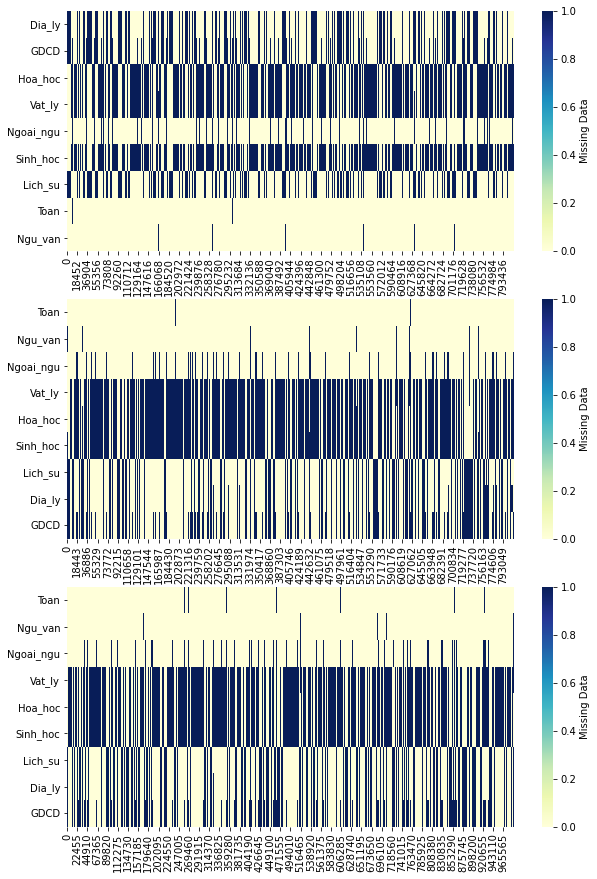

In [20]:
fig, ax = plt.subplots(3, figsize = (10,15))
#plot missing values năm 2019
sns.heatmap(df_2019p.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'}, ax = ax[0])
#plot missing values năm 2020
sns.heatmap(df_2020p.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'},ax = ax[1])
#plot missing values năm 2021
sns.heatmap(df_2021p.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'},ax = ax[2])

# Tính điểm các khối A00, A01, B01, C01, D01

In [21]:
#năm 2019
df_2019p['KhoiA'] = df_2019p['Toan'] + df_2019p['Vat_ly'] + df_2019p['Hoa_hoc']
df_2019p['KhoiB'] = df_2019p['Toan'] + df_2019p['Sinh_hoc'] + df_2019p['Hoa_hoc']
df_2019p['KhoiC'] = df_2019p['Ngu_van'] + df_2019p['Lich_su'] + df_2019p['Dia_ly']
df_2019p['KhoiA1'] = df_2019p['Toan'] + df_2019p['Vat_ly'] + df_2019p['Ngoai_ngu']
df_2019p['KhoiD1'] = df_2019p['Toan'] + df_2019p['Ngu_van'] + df_2019p['Ngoai_ngu']
#năm 2020
df_2020p['KhoiA'] = df_2020p['Toan'] + df_2020p['Vat_ly'] + df_2020p['Hoa_hoc']
df_2020p['KhoiB'] = df_2020p['Toan'] + df_2020p['Sinh_hoc'] + df_2020p['Hoa_hoc']
df_2020p['KhoiC'] = df_2020p['Ngu_van'] + df_2020p['Lich_su'] + df_2020p['Dia_ly']
df_2020p['KhoiA1'] = df_2020p['Toan'] + df_2020p['Vat_ly'] + df_2020p['Ngoai_ngu']
df_2020p['KhoiD1'] = df_2020p['Toan'] + df_2020p['Ngu_van'] + df_2020p['Ngoai_ngu']
#năm 2021
df_2021p['KhoiA'] = df_2021p['Toan'] + df_2021p['Vat_ly'] + df_2021p['Hoa_hoc']
df_2021p['KhoiB'] = df_2021p['Toan'] + df_2021p['Sinh_hoc'] + df_2021p['Hoa_hoc']
df_2021p['KhoiC'] = df_2021p['Ngu_van'] + df_2021p['Lich_su'] + df_2021p['Dia_ly']
df_2021p['KhoiA1'] = df_2021p['Toan'] + df_2021p['Vat_ly'] + df_2021p['Ngoai_ngu']
df_2021p['KhoiD1'] = df_2021p['Toan'] + df_2021p['Ngu_van'] + df_2021p['Ngoai_ngu']

In [22]:
df_2019p.head()

,Dia_ly,GDCD,Hoa_hoc,Vat_ly,Ngoai_ngu,Sinh_hoc,Lich_su,Toan,Ngu_van,KhoiA,KhoiB,KhoiC,KhoiA1,KhoiD1
0,7.75,8.75,NaN,NaN,7.6,NaN,8.25,8.2,8.00,NaN,NaN,24.0,NaN,23.800001
1,NaN,NaN,4.5,8.25,8.0,6.0,NaN,8.6,6.17,21.35,19.1,NaN,24.85,22.770000
2,4.25,5.75,NaN,NaN,NaN,NaN,4.00,5.2,4.75,NaN,NaN,13.0,NaN,NaN
3,4.75,5.00,NaN,NaN,NaN,NaN,2.25,4.4,4.50,NaN,NaN,11.5,NaN,NaN
4,8.25,7.50,NaN,NaN,4.4,NaN,7.75,5.8,6.00,NaN,NaN,22.0,NaN,16.200001


In [114]:
#Khối A00
Khoi_A00_2020  = df_2020p['KhoiA']
Khoi_A00_2020 = Khoi_A00_2020.apply(lambda x: np.round(x,2))
bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
cats = pd.cut(Khoi_A00_2020.sort_values(), bins)
Khoi_A00_2020 = pd.value_counts(cats).sort_index()
#Khối D01
KhoiD01_2020  = df_2020p['KhoiD1']
KhoiD01_2020 = KhoiD01_2020.apply(lambda x: np.round(x,2))
bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
cats = pd.cut(KhoiD01_2020.sort_values(), bins)
KhoiD01_2020 = pd.value_counts(cats).sort_index()
#Khối A01
KhoiA01_2020  = df_2020p['KhoiA1']
KhoiA01_2020 = KhoiA01_2020.apply(lambda x: np.round(x,2))
bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
cats = pd.cut(KhoiA01_2020.sort_values(), bins)
KhoiA01_2020 = pd.value_counts(cats).sort_index()
#KHối b00
KhoiB00_2020  = df_2020p['KhoiB']
KhoiB00_2020 = KhoiB00_2020.apply(lambda x: np.round(x,2))
bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
cats = pd.cut(KhoiB00_2020.sort_values(), bins)
KhoiB00_2020 = pd.value_counts(cats).sort_index()

In [115]:
#Khoi A00
Khoi_A00_2021  = df_2021p['KhoiA']
Khoi_A00_2021 = Khoi_A00_2021.apply(lambda x: np.round(x,2))
bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
cats = pd.cut(Khoi_A00_2021.sort_values(), bins)
Khoi_A00_2021 = pd.value_counts(cats).sort_index()
#Khoi D01 
KhoiD01_2021  = df_2021p['KhoiD1']
KhoiD01_2021 = KhoiD01_2021.apply(lambda x: np.round(x,2))
bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
cats = pd.cut(KhoiD01_2021.sort_values(), bins)
KhoiD01_2021 = pd.value_counts(cats).sort_index()
#Khoi A01
KhoiA01_2021  = df_2021p['KhoiA1']
KhoiA01_2021 = KhoiA01_2021.apply(lambda x: np.round(x,2))
bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
cats = pd.cut(KhoiA01_2021.sort_values(), bins)
KhoiA01_2021 = pd.value_counts(cats).sort_index()
#Khoi B00
KhoiB00_2021  = df_2021p['KhoiB']
KhoiB00_2021 = KhoiB00_2021.apply(lambda x: np.round(x,2))
bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
cats = pd.cut(KhoiB00_2021.sort_values(), bins)
KhoiB00_2021 = pd.value_counts(cats).sort_index()

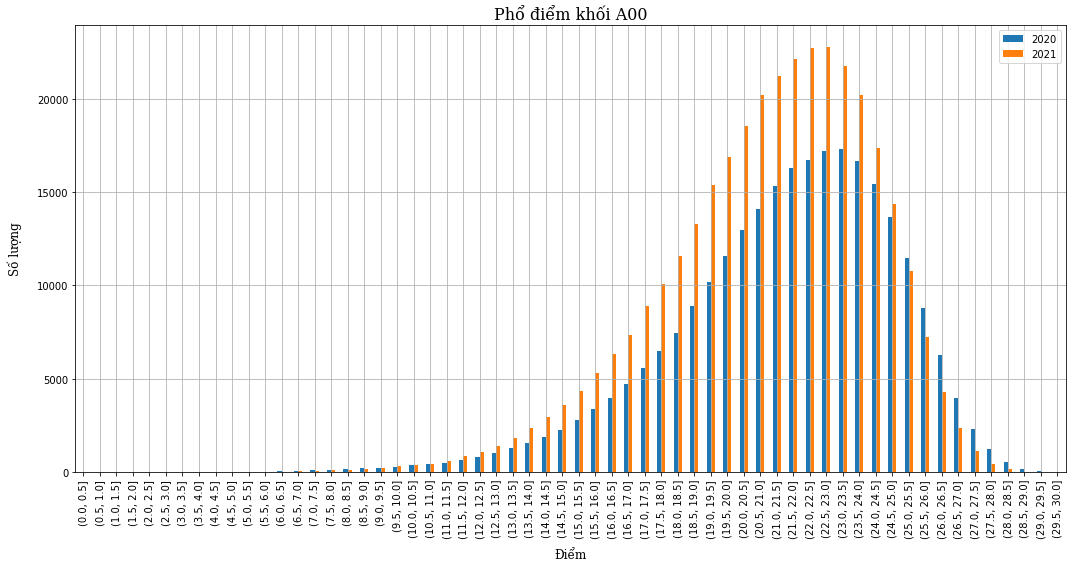

In [107]:
KhoiA00 =  pd.DataFrame(Khoi_A00_2020)
KhoiA00['2021'] =  Khoi_A00_2021
KhoiA00= KhoiA00.rename(columns = {'KhoiA': '2020'})
KhoiA00;
KhoiA00.plot(kind = 'bar', rot = 90, figsize =(15,8))
font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
            }
font_title = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
    
plt.grid()
plt.xlabel('Điểm', labelpad=10, fontdict=font)
plt.ylabel('Số lượng', labelpad=15, fontdict=font)

plt.title("Phổ điểm khối A00", fontdict=font_title)
plt.tight_layout()
plt.show()

 Nhìn vào biểu đồ trên ta có thể thấy rằng: 
 - năm 2021 số lượng thí sinh có điểm trong khoảng [22.5; 23.0] là cao nhất, còn năm 2020 thì nằm trong khoảng [23.0;23.5]
 - Bắt đầu từ mức 25 điểm trở lên thì số lượng thí sinh năm 2020 nhỉnh hơn năm 2021 một lượng nhỏ. Nếu các trường đại học vẫn giữ mức số lượng chỉ tiêu tuyển sinh cho kỳ thi THPTQG như năm 2020, thì ta có dự đoán rằng những ngành có mức điểm chuẩn từ năm 2020 có thể giảm nhẹ từ 0.5 đến 1 điểm.
 - Khoảng điểm từ 23 đên 25 có thể tăng nhẹ từ 1 đến 2 điểm.
 - Còn đối với các điểm từ 23 đổ xuống có thể tăng mạnh từ 2 đến 3 điểm, vì độ chênh lệch khá cao.

Như vậy các thí sinh đạt điểm từ 25 trở lên, thì yên đạt nguyện vọng vào các ngành có điểm chuẩn 25 điểm, còn các sinh viên còn lại phải cân nhắc kỹ khi đạt nguyện vọng vào các ngành có điểm ngang bằng với điểm thi của mình.

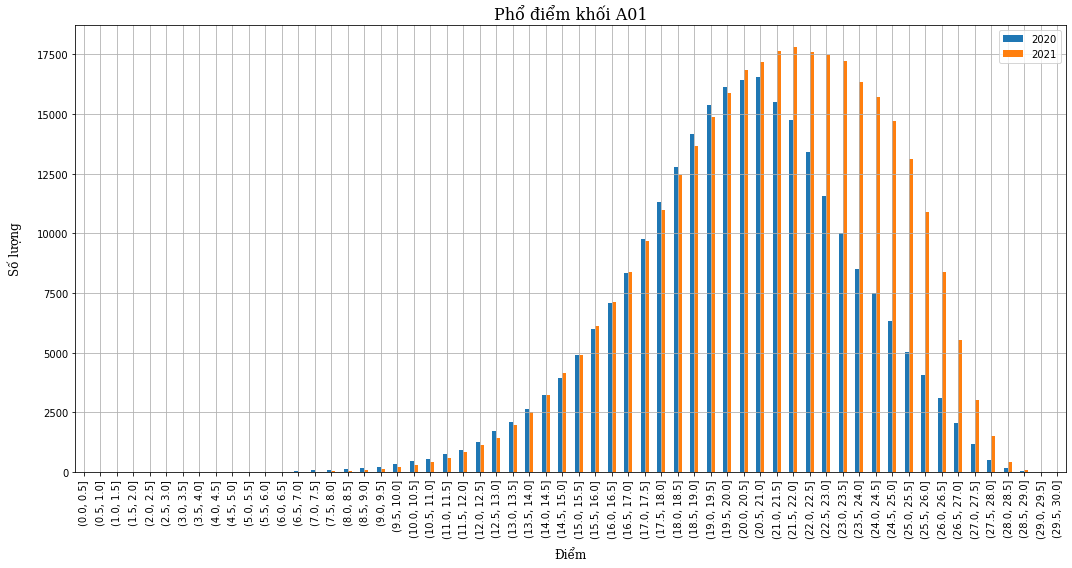

In [111]:
KhoiA01 =  pd.DataFrame(KhoiA01_2020)
KhoiA01['2021'] =  KhoiA01_2021
KhoiA01= KhoiA01.rename(columns = {'KhoiA1': '2020'})
KhoiA01;
KhoiA01.plot(kind = 'bar', rot = 90, figsize =(15,8))
font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
            }
font_title = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
    
plt.grid()
plt.xlabel('Điểm', labelpad=10, fontdict=font)
plt.ylabel('Số lượng', labelpad=15, fontdict=font)

plt.title("Phổ điểm khối A01", fontdict=font_title)
plt.tight_layout()
plt.show()

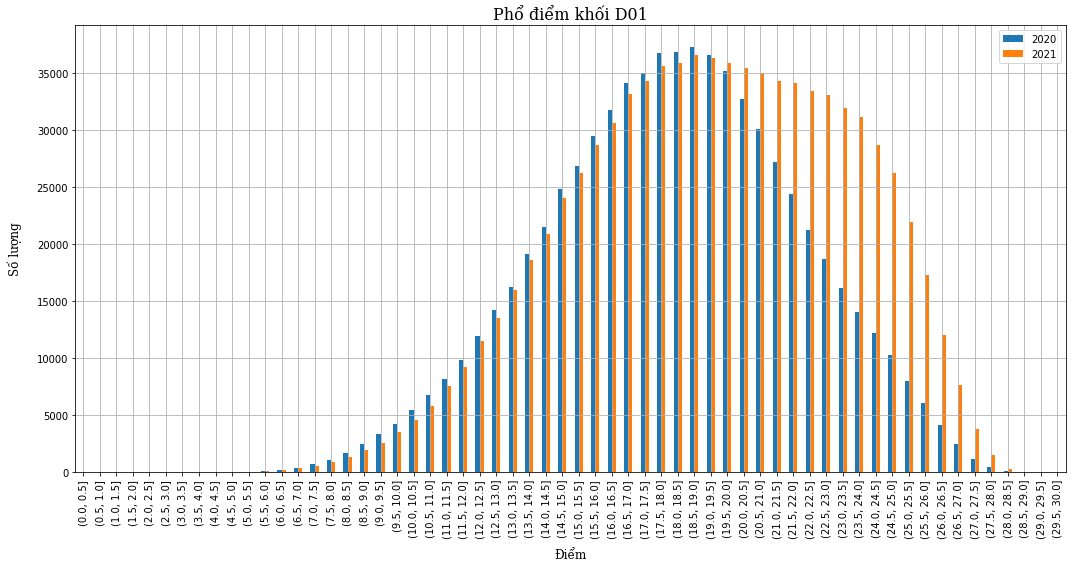

In [113]:
KhoiD01 =  pd.DataFrame(KhoiD01_2020)
KhoiD01['2021'] =  KhoiD01_2021
KhoiD01= KhoiD01.rename(columns = {'KhoiD1': '2020'})
KhoiD01;
KhoiD01.plot(kind = 'bar', rot = 90, figsize =(15,8))
font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
            }
font_title = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
    
plt.grid()
plt.xlabel('Điểm', labelpad=10, fontdict=font)
plt.ylabel('Số lượng', labelpad=15, fontdict=font)

plt.title("Phổ điểm khối D01", fontdict=font_title)
plt.tight_layout()
plt.show()

Nhìn hai biểu đồ phổ điểm khối A01 và D01 nhìn có vẻ khá tương đồng nhau nên ta có thể đưa ra nhận xét chung.
- Ta có thể số lượng thí sinh của hai khối này đạt mức điểm từ 21 đến 26 điểm năm 2021 cao hơn nhiều so với năm 2020. Với mức chênh lệch cao như vậy ta có thể ước lượng điểm chuẩn nằm trong khoảng này sẽ tăng rất mạnh khoảng từ 3 đến 4 điểm.
- Vùng từ 26 đổ lên với sự chênh lệch nhẹ có thể tăng từ 1 đên 1.5 điểm.


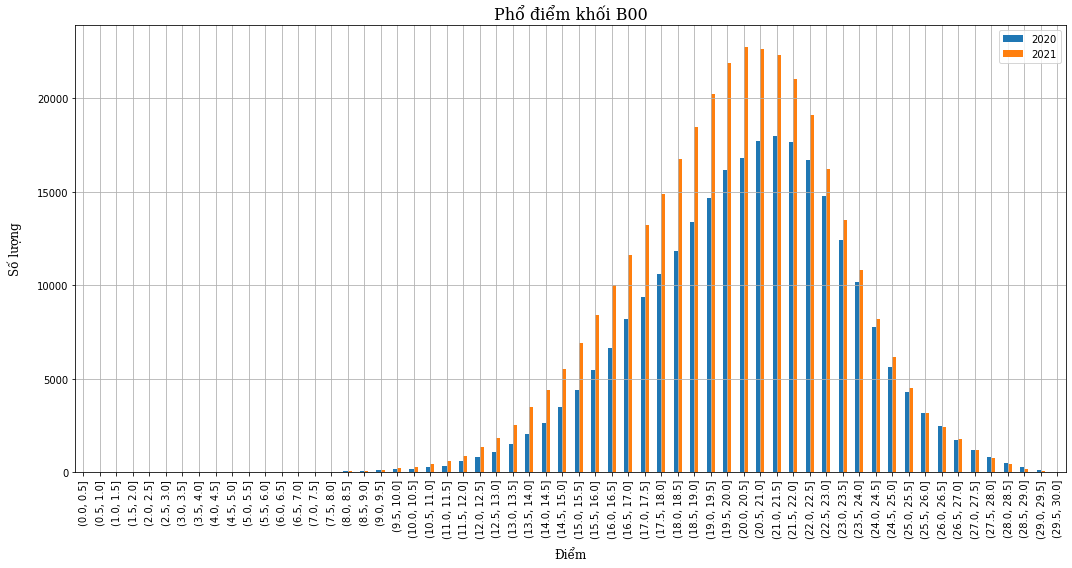

In [119]:
KhoiB00 =  pd.DataFrame(KhoiB00_2020)
KhoiB00['2021'] =  KhoiB00_2021
KhoiB00= KhoiB00.rename(columns = {'KhoiB': '2020'})
KhoiB00;
KhoiB00.plot(kind = 'bar', rot = 90, figsize =(15,8))
font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
            }
font_title = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
    
plt.grid()
plt.xlabel('Điểm', labelpad=10, fontdict=font)
plt.ylabel('Số lượng', labelpad=15, fontdict=font)

plt.title("Phổ điểm khối B00", fontdict=font_title)
plt.tight_layout()
plt.show()

Nhìn chung điểm chuẩn khối B từ mức khoản 23 điểm trở lên sẽ không có sự biến đổi nhiều. Các điểm chuẩn dưới 23 điểm nếu vẫn giữ mức chỉ tiêu cso thể tăng nhẹ.

In [121]:
df_2021p.head()

,Toan,Ngu_van,Ngoai_ngu,Vat_ly,Hoa_hoc,Sinh_hoc,Lich_su,Dia_ly,GDCD,KhoiA,KhoiB,KhoiC,KhoiA1,KhoiD1
0,2.2,3.50,NaN,NaN,NaN,NaN,2.50,5.50,NaN,NaN,NaN,11.50,NaN,NaN
1,9.2,8.25,10.0,NaN,NaN,NaN,5.75,9.75,9.25,NaN,NaN,23.75,NaN,27.450001
2,4.4,6.25,NaN,NaN,NaN,NaN,4.25,4.00,NaN,NaN,NaN,14.50,NaN,NaN
3,8.4,6.75,10.0,4.00,3.00,3.50,NaN,NaN,NaN,15.400000,14.900000,NaN,22.400000,25.150000
4,8.8,8.25,9.4,8.25,5.75,5.25,NaN,NaN,NaN,22.799999,19.799999,NaN,26.449999,26.449999


In [129]:
Tieng_anh = df_2021p.Ngoai_ngu.value_counts().sort_index()
Tieng_anh.index = Tieng_anh.index.to_series().apply(lambda x: np.round(x,2))

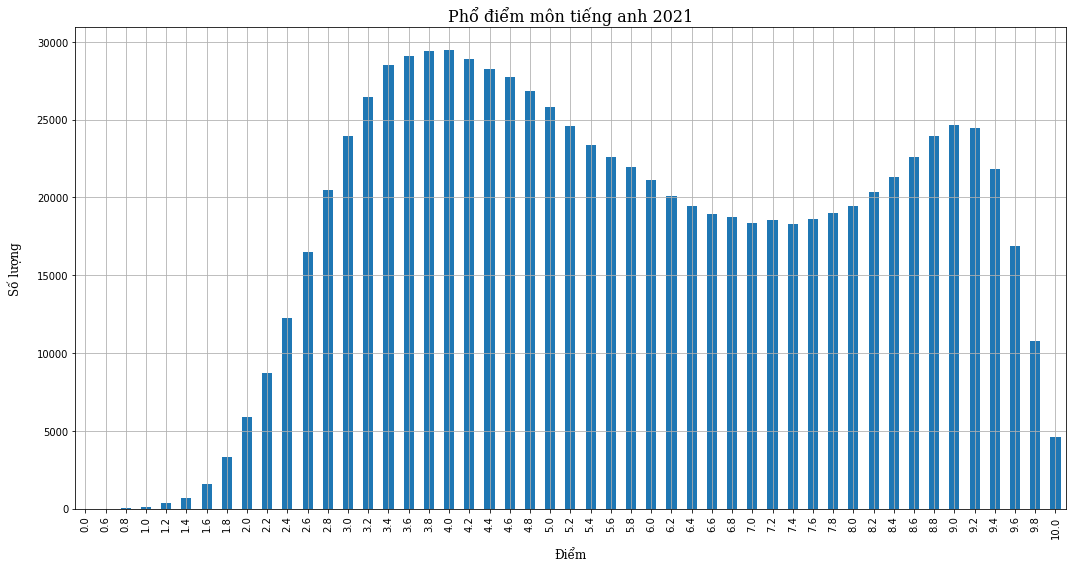

In [131]:
Tieng_anh.plot(kind = 'bar', rot = 90, figsize =(15,8))
font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
            }
font_title = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
    
plt.grid()
plt.xlabel('Điểm', labelpad=10, fontdict=font)
plt.ylabel('Số lượng', labelpad=15, fontdict=font)

plt.title("Phổ điểm môn tiếng anh 2021", fontdict=font_title)
plt.tight_layout()
plt.show()


Ta có thể thấy rằng phổ điểm Tiếng anh của thí sinh 2021 xuất hiện 2 đỉnh hình chuông. Từ đó nó liệu ta có thể nhận xét rằng có sự phân hoá giữa thí sinh thành thị được học trong môi trường phát triển tốt và các thí sinh nông thôn có sự thiệt thòi về môi trường và thiết bị hỗ trợ hay không?.Việc các trường đại học công nhận quy đổi điểm Ielts sang điểm thi đại học môn Tiếng anh cũng có thể gây lên biểu đồ này, với những thí sinh ở nông thôn rất khó để tiếp cận đến với ielts vì chi phí theo học là rất tốn kém Vd: một buổi học thêm Tiếng Anh ngoài giờ hiện nay ở ngoại thành Hà Nội có giá giao động vào khoảng 30-5ok/2h,nhưng giá của một buổi học ielts vào khoảng từ 200k-500k/2h. Với mức giá như vậy, ta so với thu nhập bình 1 tháng của các gia đình nông thôn thì nó là một chi phí khổng lồ. Nên ta cũng có thể kết luận rằng việc đồ thị phân phối trên có thể cho thấy một chút sự phân hoá vùng miền giữ nông thôn và thành thị.
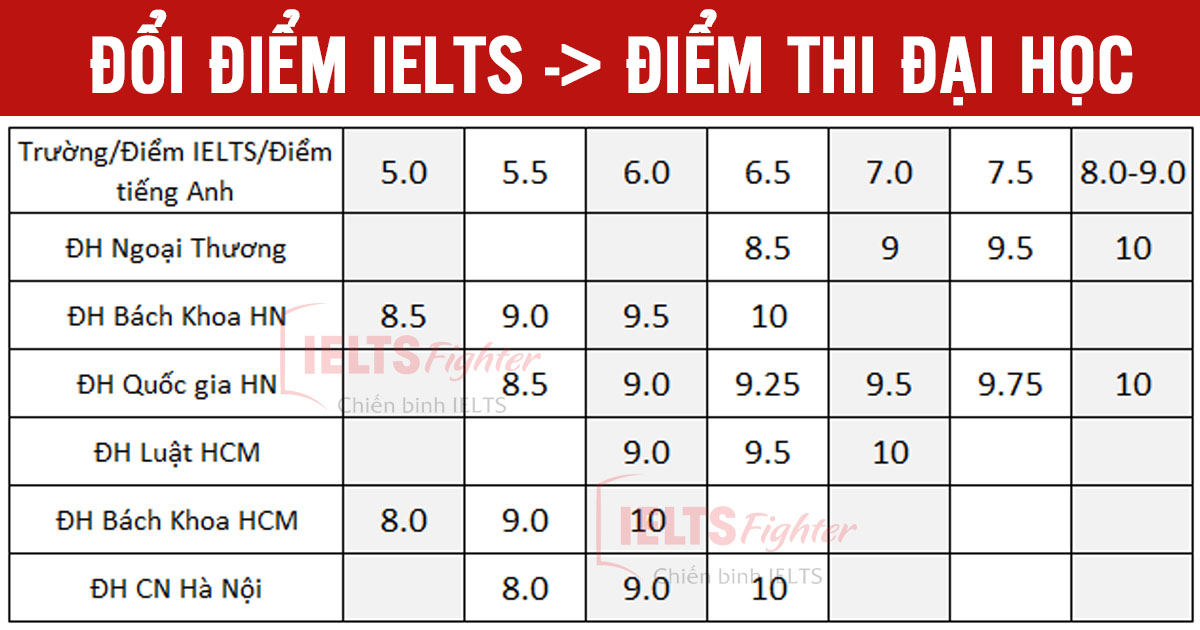
